In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from keras import backend as K
import sample_data
K.set_learning_phase(0)
%run autoencoder.py 64 4 0.25 --no_train --uneven --model_type conv --sigma 0.5 --lr 5e-4 --sim_type autoencoder/uneven/noise0.5 --filter_length 7 --nb_epoch 10 --batch_norm --embedding 4
Y = sample_data.phase_to_sin_cos(Y)
train = np.arange(args.N_train)
test = args.N_train + np.arange(args.N_test)

Using TensorFlow backend.


[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/autoencoder/uneven/noise0.5/conv_064_x4_5m04_drop25_bn_f7_emb4
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/autoencoder/uneven/noise0.5/conv_064_x4_5m04_drop25_bn_f7_emb4/weights.h5...


# Visualizing predictions

In [ ]:
%%time
pred = model.predict({'main_input': X, 'aux_input': X[:, :, [0,]]}, batch_size=500)

In [ ]:
np.mean((pred - X_raw[:, :, 1:2]) ** 2)

In [ ]:
i = test[0] - 1

In [ ]:
i += 1
if args.even:
    t = np.linspace(0, 2 * np.pi, X.shape[1])
    m = X[i, :, 0]
    pred_i = model.predict(X[[i]])[0, :, 0]
else:
    inds = (X[i, :, 0] >= 0.)
    t = X_raw[i, inds, 0]
    m_raw = X_raw[i, inds, 1]
    m = X[i, inds, 1]
    pred_i = model.predict({'main_input': X[i:i+1], 'aux_input': X[i:i+1, :, [0,]]})[0, inds, 0]

T = np.linspace(0, t.max(), 501)
def sinusoid(p, A1, A2, b):
    return lambda t: A1 * np.cos(2 * np.pi / p * t) + A2 * np.sin(2 * np.pi / p * t) + b

plt.plot(T, sinusoid(*Y[i])(T))
plt.plot(t, m, 'o')
plt.plot(t, pred_i, 'o')

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')
#plt.legend(['Noisy', 'Original'])
plt.title("MSE: {}".format(np.mean(np.abs(m_raw - pred_i) ** 1)));

In [ ]:
i += 1
inds = ~np.isnan(X_raw[i, :, 0])
t = np.cumsum(X[i, inds, 0])
m = X[i, inds, 1]
e = X[i, inds, 2]
pred_i = model.predict({'main_input': X[i:i+1], 'aux_input': X[i:i+1, :, [0, 2]]})[0, inds, 0]

plt.errorbar(t, m, e, None, 'o');
#plt.plot(t, pred_i, 'o');

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')

#plt.legend(['Noisy', 'Original'])

# Visualizing training progress

In [ ]:
import glob
import os

log_files = glob.glob(os.path.join('keras_logs', 'autoencoder/uneven/noise0') + '/*.csv')
logs = [pd.read_csv(f, usecols=['Wall time', 'Step', 'Value']) for f in log_files]
for log, f in zip(logs, log_files):
    label = f[(f.rfind('run_') + 4):f.rfind(',')] + ' ' + ('Validation' if 'val' in f else 'Training')
    log.columns = [label if c == 'Value' else c for c in log.columns]
    log['Wall time'] -= log['Wall time'].min()
time_logs = pd.concat([l.set_index('Wall time').drop('Step', axis=1) for l in logs], axis=1)
step_logs = pd.concat([l.set_index('Step').drop('Wall time', axis=1) for l in logs], axis=1)
step_logs.head(10)

In [ ]:
step_logs.plot?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

colors = sns.color_palette(n_colors=int(len(step_logs.columns) / 2))
for i, c in enumerate(step_logs.columns):
    step_logs[c].dropna().plot(ax=ax[0], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
    time_logs[c].dropna().plot(ax=ax[1], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
ax[0].set_ylabel('Loss');
ax[1].set_ylabel('Loss');
ax[1].set_xlabel('Wall time (s)');

# Visualizing embeddings

In [3]:
%%time
inds = np.arange(args.N_train, args.N_train + args.N_test)
encode_layer = [l for l in model.layers if l.name == 'encoding'][0]
if args.even:
    encode = K.function([model.layers[0].input], [encode_layer.output])
    encoding, = encode([X[inds]])
else:
    inputs = [l for l in model.layers if 'Input' in str(l)]
    encode = K.function([inputs[0].input, inputs[1].input], [encode_layer.output])
    encoding, = encode([X[inds], X[inds, :, 0:1]])

CPU times: user 2.93 s, sys: 635 ms, total: 3.56 s
Wall time: 667 ms


In [ ]:
np.mean((m - pred_i) ** 2)

In [ ]:
S = np.corrcoef(encoding, Y[:encoding.shape[0]], rowvar=0)[:8, 8:]
print(pd.DataFrame(S))
plt.imshow(S, cmap='viridis', interpolation='none')
plt.colorbar()

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 0], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 1], Y[:encoding.shape[0], 1], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 2], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 3], Y[:encoding.shape[0], 3], kind='hex')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=128)
#model = ElasticNet()
#model = SVR(kernel='rbf')

model.fit(encoding, Y[:encoding.shape[0], 0])

In [ ]:
encoding_test = encode([X[test]])[0]
Y_pred = model.predict(encoding_test)

In [ ]:
#sns.jointplot(Y[test, 0], Y_pred[:, 0])
sns.jointplot(Y[test, 0], Y_pred)

In [40]:
x = pd.date_range(start='1985-10-11', end='2017-06-01')
oys = np.array([1. if x_i >= pd.Timestamp('2014-03-01') else 0. for x_i in x])
elec = np.array([1. if x_i >= pd.Timestamp('2016-12-19') else 0. for x_i in x])
ali = np.array([1. if x_i >= pd.Timestamp('2009-9-01') else 0. for x_i in x])
team = np.array([1. if x_i >= pd.Timestamp('2017-1-30') else 0. for x_i in x])

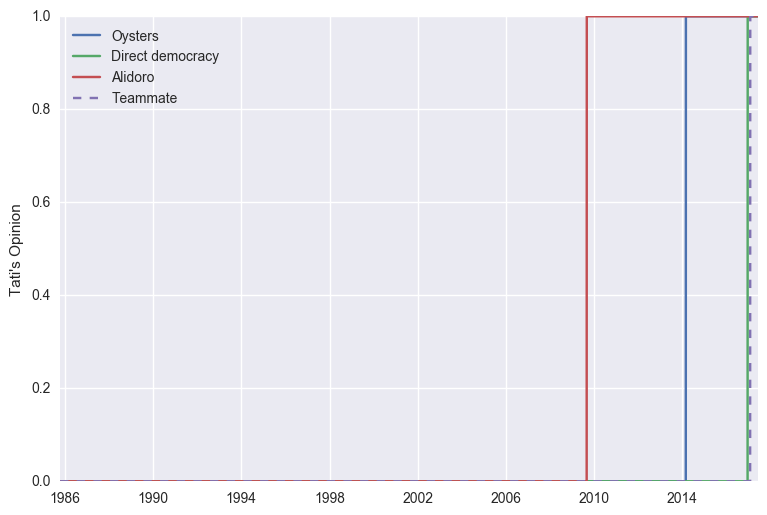

In [42]:
plt.plot(x, oys)
plt.plot(x, elec)
plt.plot(x, ali)
plt.plot(x, team, linestyle='--')
plt.ylabel('Tati\'s Opinion')
plt.legend(['Oysters', 'Direct democracy', 'Alidoro', 'Teammate'], loc='upper left')
plt.savefig('/tmp/tati.png')